In [1]:
%load_ext autoreload
%autoreload 2

import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from seqme import ModelCache, compute_metrics, show_table
from seqme.metrics import Precision, Recall, Fold
from seqme.models import Esm2, Esm2Checkpoint
from seqme.plots import plot_embeddings, plot_kde, tsne
from seqme.utils import random_subset, read_fasta_file

from config_paths import PATHS_FOR_CONTROL, PATHS_FOR_MODELS

/raid/brunopsz/Hackaton/pepme/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check what is the impact of K on the results

In [2]:
K_VALUES = [3, 5, 8, 12, 16, 20, 24, 28, 32]

device = "cuda:3" if torch.cuda.is_available() else "cpu"

In [ ]:
datasets = {name: read_fasta_file(path) for name, path in (PATHS_FOR_CONTROL | PATHS_FOR_MODELS).items()}

In [4]:
CACHE_PATH = "../cache.pkl"

if CACHE_PATH:
    with open(CACHE_PATH, "rb") as f:
        init_cache = pickle.load(f)
else:
    init_cache = None

In [5]:
cache = ModelCache(
    models={},
    init_cache=init_cache,
)

In [6]:
esm = "esm2-embed"
esm_finetuned = "esm2-pretrain"
hydramp_model = "hydramp-embed"
vae_transformer_model = "vae_transformer-embed"

In [7]:
datasets_to_calculate_names = [
    "positives",
    "HydrAMP"
]

n_samples = 10000
seed = 42

datasets_to_calculate = {
    name: random_subset(datasets[name], n_samples=n_samples, seed=seed)
    if len(datasets[name]) > n_samples
    else datasets[name]
    for name in datasets_to_calculate_names
}

In [8]:
embedder_esm = cache.model(esm)
embedder_esm_finetuned = cache.model(esm_finetuned)

In [9]:
metrics_esm = []
metrics_esm_finetuned = []
seqs_ref = datasets_to_calculate["positives"]

for k in K_VALUES:
    metrics_esm.extend([
        Precision(
            neighborhood_size=k,
            reference=seqs_ref,
            embedder=cache.model(esm),
            strict=True, 
            device=device, 
            embedder_name=esm + f"-k={k}"
        ),
        Recall(
            neighborhood_size=k,
            reference=seqs_ref,
            embedder=cache.model(esm),
            strict=True,
            device=device,
            embedder_name=esm + f"-k={k}",
        )
    ])

    metrics_esm_finetuned.extend([
        Precision(
            neighborhood_size=k,
            reference=seqs_ref,
            embedder=cache.model(esm_finetuned),
            strict=True,
            device=device,
            embedder_name=esm_finetuned + f"-k={k}",
        ),
        Recall(
            neighborhood_size=k,
            reference=seqs_ref,
            embedder=cache.model(esm_finetuned),
            strict=True,
            device=device,
            embedder_name=esm_finetuned + f"-k={k}",
        ),
    ])


In [10]:
df_1 = compute_metrics(datasets_to_calculate, metrics_esm)

  0%|          | 0/36 [00:00<?, ?it/s, data=positives, metric=Precision@esm2-embed-k=3]

100%|██████████| 36/36 [00:38<00:00,  1.06s/it, data=HydrAMP, metric=Recall@esm2-embed-k=32]     


In [11]:
df_2 = compute_metrics(datasets_to_calculate, metrics_esm_finetuned)

  0%|          | 0/36 [00:00<?, ?it/s, data=positives, metric=Precision@esm2-pretrain-k=3]

100%|██████████| 36/36 [00:38<00:00,  1.06s/it, data=HydrAMP, metric=Recall@esm2-pretrain-k=32]     


In [12]:
show_table(df_1, color=None)

,Precision@esm2-embed-k=3↑,Recall@esm2-embed-k=3↑,Precision@esm2-embed-k=5↑,Recall@esm2-embed-k=5↑,Precision@esm2-embed-k=8↑,Recall@esm2-embed-k=8↑,Precision@esm2-embed-k=12↑,Recall@esm2-embed-k=12↑,Precision@esm2-embed-k=16↑,Recall@esm2-embed-k=16↑,Precision@esm2-embed-k=20↑,Recall@esm2-embed-k=20↑,Precision@esm2-embed-k=24↑,Recall@esm2-embed-k=24↑,Precision@esm2-embed-k=28↑,Recall@esm2-embed-k=28↑,Precision@esm2-embed-k=32↑,Recall@esm2-embed-k=32↑
positives,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
HydrAMP,0.49,0.48,0.66,0.59,0.78,0.67,0.87,0.74,0.91,0.80,0.94,0.83,0.95,0.85,0.96,0.87,0.97,0.88


In [13]:
show_table(df_2, color=None)

,Precision@esm2-pretrain-k=3↑,Recall@esm2-pretrain-k=3↑,Precision@esm2-pretrain-k=5↑,Recall@esm2-pretrain-k=5↑,Precision@esm2-pretrain-k=8↑,Recall@esm2-pretrain-k=8↑,Precision@esm2-pretrain-k=12↑,Recall@esm2-pretrain-k=12↑,Precision@esm2-pretrain-k=16↑,Recall@esm2-pretrain-k=16↑,Precision@esm2-pretrain-k=20↑,Recall@esm2-pretrain-k=20↑,Precision@esm2-pretrain-k=24↑,Recall@esm2-pretrain-k=24↑,Precision@esm2-pretrain-k=28↑,Recall@esm2-pretrain-k=28↑,Precision@esm2-pretrain-k=32↑,Recall@esm2-pretrain-k=32↑
positives,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
HydrAMP,0.61,0.53,0.75,0.66,0.85,0.75,0.91,0.81,0.94,0.85,0.96,0.88,0.97,0.90,0.98,0.92,0.98,0.93


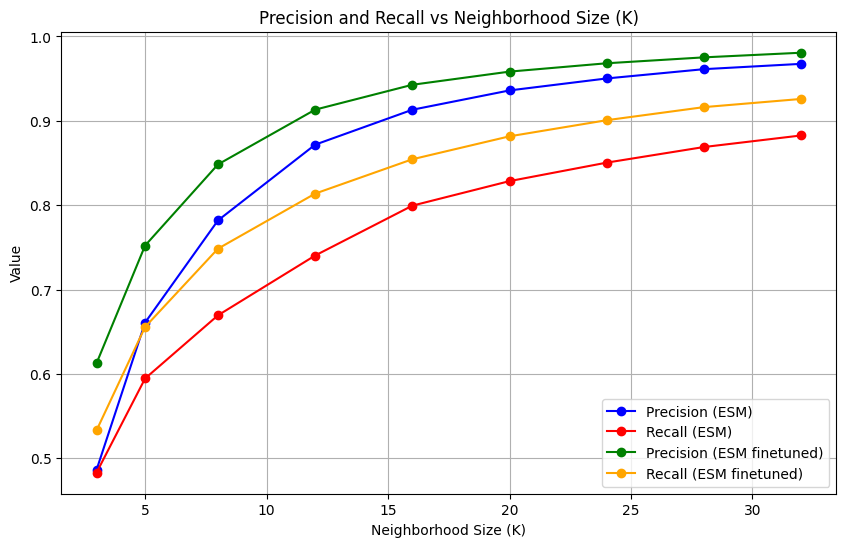

In [ ]:
precisions_esm = [df_1.loc['HydrAMP', col] for col in df_1.columns if (col[0].startswith('Precision') and col[1] == 'value')]
recalls_esm = [df_1.loc['HydrAMP', col] for col in df_1.columns if (col[0].startswith('Recall') and col[1] == 'value')]

precisions_esm_finetuned = [df_2.loc['HydrAMP', col] for col in df_2.columns if (col[0].startswith('Precision') and col[1] == 'value')]
recalls_esm_finetuned = [df_2.loc['HydrAMP', col] for col in df_2.columns if (col[0].startswith('Recall') and col[1] == 'value')]

plt.figure(figsize=(10, 6))
plt.plot(K_VALUES, precisions_esm, marker='o', label='Precision (ESM)', color='blue')
plt.plot(K_VALUES, recalls_esm, marker='o', label='Recall (ESM)', color='red')

plt.plot(K_VALUES, precisions_esm_finetuned, marker='o', label='Precision (ESM finetuned)', color='green')
plt.plot(K_VALUES, recalls_esm_finetuned, marker='o', label='Recall (ESM finetuned)', color='orange')

plt.xlabel('Neighborhood Size (K)')
plt.ylabel('Value')
plt.title('Precision and Recall vs Neighborhood Size (K)')
plt.legend()
plt.grid(True)

plt.show()

### Check dataset size impact 

In [15]:
DATASET_SIZES = [100, 200, 300, 500, 1000, 1500, 2000, 3000]

In [ ]:
import numpy as np
import pandas as pd

df_esm_all = []
df_esm_finetuned_all = []

N_RUNS = 20
SEEDS = range(42, 42 + N_RUNS)

for seed in SEEDS:
    df_esm = []
    df_esm_finetuned = []

    for size in DATASET_SIZES:
        
        datasets_to_calculate_names = [
            "positives",
            "HydrAMP"
        ]

        n_samples = size

        datasets_to_calculate = {
            name: random_subset(datasets[name], n_samples=n_samples, seed=seed)
            if len(datasets[name]) > n_samples
            else datasets[name]
            for name in datasets_to_calculate_names
        }

        metrics_esm = []
        metrics_esm_finetuned = []
        seqs_ref = datasets_to_calculate["positives"]
        
        metrics_esm.extend([
            Precision(
                neighborhood_size=3,
                reference=seqs_ref,
                embedder=cache.model(esm),
                strict=True,
                device=device,
                embedder_name=esm + f"-{size}"
            ),
            Recall(
                neighborhood_size=3,
                reference=seqs_ref,
                embedder=cache.model(esm),
                strict=True,
                device=device,
                embedder_name=esm + f"-{size}",
            )
        ])

        metrics_esm_finetuned.extend([
            Precision(
                neighborhood_size=3,
                reference=seqs_ref,
                embedder=cache.model(esm_finetuned),
                strict=True,
                device=device,
                embedder_name=esm_finetuned + f"-{size}",
            ),
            Recall(
                neighborhood_size=3,
                reference=seqs_ref,
                embedder=cache.model(esm_finetuned),
                strict=True,
                device=device,
                embedder_name=esm_finetuned + f"-{size}",
            ),
        ])

        df_1 = compute_metrics(datasets_to_calculate, metrics_esm)
        df_esm.append(df_1.loc['HydrAMP'])
        df_2 = compute_metrics(datasets_to_calculate, metrics_esm_finetuned)
        df_esm_finetuned.append(df_2.loc['HydrAMP'])

    df_esm_all.append(pd.DataFrame(df_esm))
    df_esm_finetuned_all.append(pd.DataFrame(df_esm_finetuned))

df_esm_all = pd.concat(df_esm_all, keys=SEEDS)
df_esm_finetuned_all = pd.concat(df_esm_finetuned_all, keys=SEEDS)

df_esm_mean = df_esm_all.groupby(level=1).mean()
df_esm_std = df_esm_all.groupby(level=1).std()

df_esm_finetuned_mean = df_esm_finetuned_all.groupby(level=1).mean()
df_esm_finetuned_std = df_esm_finetuned_all.groupby(level=1).std()

print("=== ESM mean ===")
print(df_esm_mean)
print("=== ESM std ===")
print(df_esm_std)

print("=== ESM finetuned mean ===")
print(df_esm_finetuned_mean)
print("=== ESM finetuned std ===")
print(df_esm_finetuned_std)


  0%|          | 0/4 [00:00<?, ?it/s, data=positives, metric=Precision@esm2-embed-100]

100%|██████████| 4/4 [00:00<00:00,  8.65it/s, data=HydrAMP, metric=Recall@esm2-pretrain-3000]     

=== ESM mean ===
        Precision@esm2-embed-100           Recall@esm2-embed-100            \
                           value deviation                 value deviation   
HydrAMP                    0.679       NaN                0.4895       NaN   

        Precision@esm2-embed-200           Recall@esm2-embed-200            \
                           value deviation                 value deviation   
HydrAMP                    0.699       NaN               0.50775       NaN   

        Precision@esm2-embed-300            ... Recall@esm2-embed-1500  \
                           value deviation  ...                  value   
HydrAMP                 0.653667       NaN  ...               0.518433   

                  Precision@esm2-embed-2000           Recall@esm2-embed-2000  \
        deviation                     value deviation                  value   
HydrAMP       NaN                  0.565525       NaN               0.505325   

                  Precision@esm2-embed-3000      

In [17]:
df_esm_mean

Precision@esm2-embed-100           Recall@esm2-embed-100            \
                           value deviation                 value deviation   
HydrAMP                    0.679       NaN                0.4895       NaN   

        Precision@esm2-embed-200           Recall@esm2-embed-200            \
                           value deviation                 value deviation   
HydrAMP                    0.699       NaN               0.50775       NaN   

        Precision@esm2-embed-300            ... Recall@esm2-embed-1500  \
                           value deviation  ...                  value   
HydrAMP                 0.653667       NaN  ...               0.518433   

                  Precision@esm2-embed-2000           Recall@esm2-embed-2000  \
        deviation                     value deviation                  value   
HydrAMP       NaN                  0.565525       NaN               0.505325   

                  Precision@esm2-embed-3000           Recall@esm2-embed-3000  \
        deviation                     value deviation                  value   
HydrAMP       NaN                  0.548717       NaN                 0.5053   

                   
        deviation  
HydrAMP       NaN  

[1 rows x 32 columns]

In [18]:
import pandas as pd

combined_df_esm = (pd.concat(df_esm, axis=0)).to_frame().T
combined_df_esm_finetuned = (pd.concat(df_esm_finetuned, axis=0)).to_frame().T

In [ ]:
combined_df_esm

Precision@esm2-embed-100           Recall@esm2-embed-100            \
                           value deviation                 value deviation   
HydrAMP                     0.54       NaN                  0.44       NaN   

        Precision@esm2-embed-200           Recall@esm2-embed-200            \
                           value deviation                 value deviation   
HydrAMP                    0.745       NaN                 0.665       NaN   

        Precision@esm2-embed-300            ... Recall@esm2-embed-1500  \
                           value deviation  ...                  value   
HydrAMP                     0.59       NaN  ...               0.515333   

                  Precision@esm2-embed-2000           Recall@esm2-embed-2000  \
        deviation                     value deviation                  value   
HydrAMP       NaN                    0.4895       NaN                 0.5015   

                  Precision@esm2-embed-3000           Recall@esm2-embed-3000  \
        deviation                     value deviation                  value   
HydrAMP       NaN                  0.531667       NaN               0.487333   

                   
        deviation  
HydrAMP       NaN  

[1 rows x 32 columns]

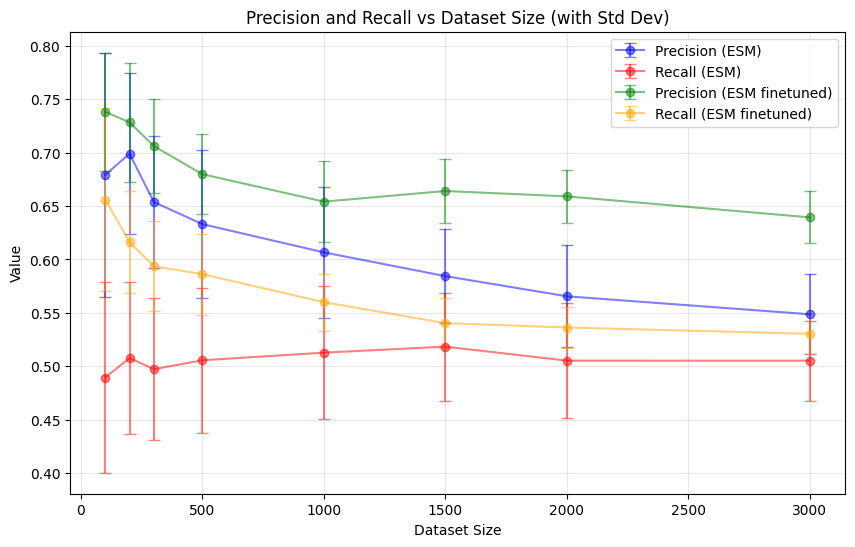

In [ ]:
precisions_esm_mean = [df_esm_mean.loc['HydrAMP', col] 
                       for col in df_esm_mean.columns 
                       if (col[0].startswith('Precision') and col[1] == 'value')]
recalls_esm_mean = [df_esm_mean.loc['HydrAMP', col] 
                    for col in df_esm_mean.columns 
                    if (col[0].startswith('Recall') and col[1] == 'value')]

precisions_esm_finetuned_mean = [df_esm_finetuned_mean.loc['HydrAMP', col] 
                                  for col in df_esm_finetuned_mean.columns 
                                  if (col[0].startswith('Precision') and col[1] == 'value')]
recalls_esm_finetuned_mean = [df_esm_finetuned_mean.loc['HydrAMP', col] 
                               for col in df_esm_finetuned_mean.columns 
                               if (col[0].startswith('Recall') and col[1] == 'value')]

precisions_esm_std = [df_esm_std.loc['HydrAMP', col] 
                      for col in df_esm_std.columns 
                      if (col[0].startswith('Precision') and col[1] == 'value')]
recalls_esm_std = [df_esm_std.loc['HydrAMP', col] 
                   for col in df_esm_std.columns 
                   if (col[0].startswith('Recall') and col[1] == 'value')]

precisions_esm_finetuned_std = [df_esm_finetuned_std.loc['HydrAMP', col] 
                                 for col in df_esm_finetuned_std.columns 
                                 if (col[0].startswith('Precision') and col[1] == 'value')]
recalls_esm_finetuned_std = [df_esm_finetuned_std.loc['HydrAMP', col] 
                              for col in df_esm_finetuned_std.columns 
                              if (col[0].startswith('Recall') and col[1] == 'value')]

plt.figure(figsize=(10, 6))

plt.errorbar(DATASET_SIZES, precisions_esm_mean, yerr=precisions_esm_std,
             marker='o', label='Precision (ESM)', color='blue', capsize=4, alpha=0.5)
plt.errorbar(DATASET_SIZES, recalls_esm_mean, yerr=recalls_esm_std,
             marker='o', label='Recall (ESM)', color='red', capsize=4, alpha=0.5)

plt.errorbar(DATASET_SIZES, precisions_esm_finetuned_mean, yerr=precisions_esm_finetuned_std,
             marker='o', label='Precision (ESM finetuned)', color='green', capsize=4, alpha=0.5)
plt.errorbar(DATASET_SIZES, recalls_esm_finetuned_mean, yerr=recalls_esm_finetuned_std,
             marker='o', label='Recall (ESM finetuned)', color='orange', capsize=4, alpha=0.5)

plt.xlabel('Dataset Size')
plt.ylabel('Value')
plt.title('Precision and Recall vs Dataset Size (with Std Dev)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

